<a href="https://colab.research.google.com/github/soupsoupr/StrokeSegmentation/blob/main/test_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [763]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [764]:
import nibabel as nib
import os
# Set the file path to the directory containing the DWI data files
file_path = '/content/drive/MyDrive/ISLES/dataset-ISLES22^public^unzipped^version'

for example_case in range(1,11): # for the first 10 data from ISLES22
    # Set images path.
    dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
    mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

# Load image data.
dwi_data = []
mask_data = []

dwi_data = nib.load(dwi_path).get_fdata()
mask_data = nib.load(mask_path).get_fdata()

In [765]:
import numpy as np
import cv2

# Duplicate both dwi and label data into two new lists for future process
data_paths = []
mask_paths = []

for i in dwi_data:
    data_paths.append(i)

for i in mask_data:
    mask_paths.append(i)

In [766]:
print(mask_data[0].shape)

(112, 72)


# Import Libraries

In [767]:
from PIL import Image
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

check dwi image

In [768]:
# slice_idx = dwi_data.shape[2] // 2
# dwi_slice = dwi_data[:, :, slice_idx]

# fig, ax = plt.subplots(figsize=(2,2))
# ax.imshow(dwi_slice.T, origin='lower', cmap='gray')

# ax.set_title('dwi slice')

# ax.set_axis_off()
# plt.show()

# Define a custom PyTorch dataset

In [769]:
class CustomDataset(Dataset):
    def __init__ (self, img, mask, transformer):
        self.img = img
        self.mask = mask
        self.transformer = transformer

    def __len__ (self):
        return len(self.img)

    def __getitem__ (self, index):
        img_name = self.img[index]
        mask_name = self.mask[index]

        img_open = Image.fromarray(img_name)
        img = self.transformer(img_open)

        mask_open = Image.fromarray(mask_name)
        mask = self.transformer(mask_open)

        # mask = mask.unsqueeze(1)  # Add a channel dimension

        return img, mask

# Data preprocessing and augmentation

In [770]:
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# Split dataset into training and testing sets

In [771]:
train_files, test_files = train_test_split(data_paths, test_size=0.2, random_state=42)

In [772]:
# Train and test sets initalization
train_dataset = CustomDataset(data_paths, mask_paths, train_transformer)
test_dataset = CustomDataset(data_paths, mask_paths, test_transformer)

# Create data loaders

In [773]:
# Train and test set data loaders initalization
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Compare ground truth and result

In [774]:
# data, label = next(iter(train_loader))
# plt.figure(figsize=(12,8))
# for i, (data, label) in enumerate(zip(data[:4], label[:4])):
#     data = data.permute(1,2,0).numpy()
#     label = label.numpy()
#     plt.subplot(2,4,i+1)
#     plt.imshow(data)
#     plt.subplot(2,4,i+5)
#     plt.imshow(label)

Images batch shape: torch.Size([1, 1, 112, 72])
Labels batch shape: torch.Size([1, 1, 112, 72])


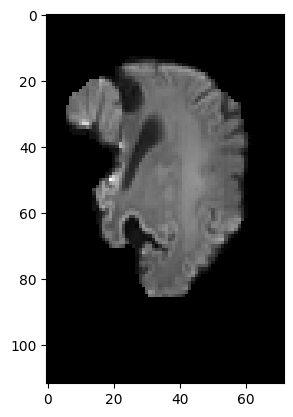

Label: tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


In [775]:
# Display image and label.
train_images, train_labels = next(iter(train_loader))
print(f"Images batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_images[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")

# Define a U-Net architecture for segmentation

In [776]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.bottleneck(x1)
        x3 = self.decoder(x2)
        return x3

In [777]:
in_channels = 1    # Number of input channels
out_channels = 1   # Number of output channels (binary segmentation)
model = UNet(in_channels, out_channels)

# Define loss and optimizer

In [778]:
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [779]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, masks)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/10] - Loss: -544334.2264
Epoch [2/10] - Loss: -40624948.9934
Epoch [3/10] - Loss: -444047801.3015
Epoch [4/10] - Loss: -2010362703.2009
Epoch [5/10] - Loss: -5924029639.6652
Epoch [6/10] - Loss: -13781413158.1875
Epoch [7/10] - Loss: -27308383346.5000
Epoch [8/10] - Loss: -48534998154.5714
Epoch [9/10] - Loss: -79327887600.2857
Epoch [10/10] - Loss: -122765452538.2857


# Evaluation

In [782]:
from sklearn.metrics import jaccard_score

# Initialize lists to store evaluation results
dice_scores = []
jaccard_scores = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        # Forward pass
        outputs = model(images)

        # Calculate the predicted class labels (assuming binary segmentation)
        predicted_labels = (outputs > 0.5).float()

        # Convert tensors to numpy arrays
        predicted_labels = predicted_labels.cpu().numpy()
        targets = masks.cpu().numpy()

        # Calculate Dice coefficient and Jaccard index for each batch
        for i in range(len(predicted_labels)):
            intersection = np.logical_and(predicted_labels[i], targets[i])
            union = np.logical_or(predicted_labels[i], targets[i])

            dice = (2.0 * np.sum(intersection)) / (np.sum(predicted_labels[i]) \
                                                   + np.sum(targets[i]) + 1e-5)
            # jaccard = jaccard_score(targets[i].flatten(), predicted_labels[i].flatten())

            dice_scores.append(dice)
            # jaccard_scores.append(jaccard)

# Calculate the average scores
avg_dice_score = np.mean(dice_scores)
# avg_jaccard_score = np.mean(jaccard_scores)

print(f'Average Dice Coefficient: {avg_dice_score}')
# print(f'Average Jaccard Index: {avg_jaccard_score}')


Average Dice Coefficient: 0.0
